# COVID-19 Time Series Analysis

In [221]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import ExponentialSmoothing
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Activation, Dropout
from sklearn.metrics import mean_squared_error

%matplotlib inline

Using TensorFlow backend.


In [2]:
raw = pd.read_csv('CONVENIENT_global_confirmed_cases.csv')
raw.head()

,Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,...,United Kingdom.10,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Yemen,Zambia,Zimbabwe
0,Province/State,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Australian Capital Territory,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1/23/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
2,1/24/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1/25/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1/26/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Total Number of Days:  330
Number of Days since 1st Case:  327
First Day-2020-01-23 00:00:00 	 Last Day-2020-12-17 00:00:00


Text(0.5, 1.0, 'COVID-19 Cases in Japan')

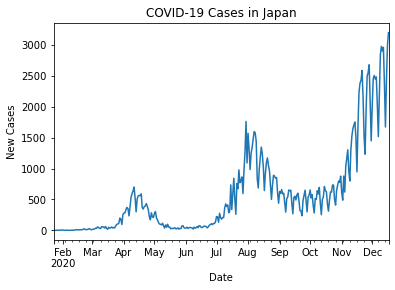

In [69]:
data_jp = raw[['Country/Region','Japan']].iloc[1:,:].reset_index().drop('index', axis=1)
data_jp.columns = ['Date','New_Cases']
data_jp['Date'] = data_jp['Date'].astype('datetime64[D]')
data_jp.set_index('Date', inplace=True)
print('Total Number of Days: ', len(data_jp))
print('Number of Days since 1st Case: ',len(data_jp.loc[data_jp[data_jp.New_Cases!=0].index[0]:,:]))
print('First Day-{} \t Last Day-{}'.format(data_jp.index[0], data_jp.index[-1]))

data_jp.plot(legend=None)
plt.ylabel('New Cases')
plt.title('COVID-19 Cases in Japan')

## Stationarity

### Trend and Heteroscedasticity

In [72]:
chunks = np.split(data_jp.New_Cases , indices_or_sections=10)
print("{} | {:7} | {}".format("Chunk", "Mean",
"Variance"))
print("−" * 26)
for i, chunk in enumerate(chunks , 1):
    print("{:5} | {:.6} | {:.6}".format(i,np.mean(chunk), np.var(chunk)))

Chunk | Mean    | Variance
−−−−−−−−−−−−−−−−−−−−−−−−−−
    1 | 4.78788 | 33.8035
    2 | 47.5152 | 1330.07
    3 | 380.485 | 22599.2
    4 | 77.3636 | 4629.69
    5 | 85.7879 | 3789.32
    6 | 790.788 | 2.03812e+05
    7 | 833.333 | 92508.1
    8 | 496.606 | 17339.0
    9 | 832.152 | 1.47568e+05
   10 | 2237.48 | 3.00506e+05


It is evident that the data contains a trend and heteroscedasticity. Let's fix the second using the log transform.

<AxesSubplot:xlabel='Date'>

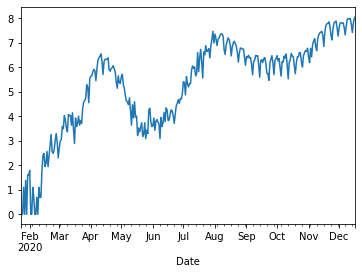

In [73]:
data_jp['log_cases'] = np.log1p(data_jp['New_Cases'])
data_jp['log_cases'].plot(legend=None)

In [75]:
chunks = np.split(data_jp.log_cases , indices_or_sections=10)
print("{} | {:7} | {}".format("Chunk", "Mean",
"Variance"))
print("−" * 26)
for i, chunk in enumerate(chunks , 1):
    print("{:5} | {:.6} | {:.6}".format(i,np.mean(chunk), np.var(chunk)))

Chunk | Mean    | Variance
−−−−−−−−−−−−−−−−−−−−−−−−−−
    1 | 1.25068 | 1.07034
    2 | 3.66776 | 0.412717
    3 | 5.85602 | 0.19435
    4 | 4.08565 | 0.49421
    5 | 4.2651 | 0.365312
    6 | 6.4839 | 0.423998
    7 | 6.65839 | 0.141549
    8 | 6.1674 | 0.0938931
    9 | 6.63042 | 0.182764
   10 | 7.67829 | 0.0775126


With this transformation, it seems that the data has a constant variance.

### Autocorrelation

In [103]:
def difference(series):
    arr = []
    arr.append(np.nan)
    for i in range(len(series)-1):
        dif = series[i+1]-series[i]
        arr.append(dif)
        
    return arr

<AxesSubplot:ylabel='Frequency'>

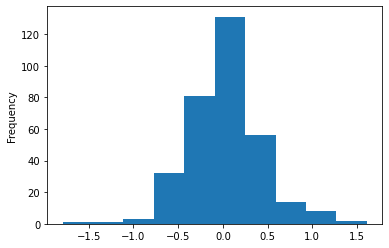

In [107]:
data_jp['Difference'] = difference(data_jp.log_cases)
data_jp.Difference.plot(kind='hist', bins=10)

<AxesSubplot:xlabel='Date'>

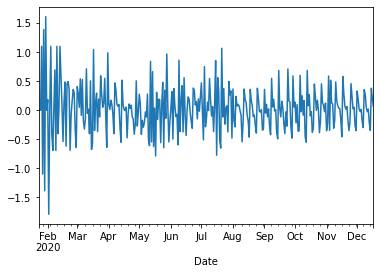

In [108]:
data_jp['Difference'].plot(legend=None)

It seems that the series is now stationary.

### ADF Test

In [111]:
adf, pvalue , usedlag , n_obs , critical_values , icbest = adfuller(data_jp.Difference[1:])
print('P-value: ', pvalue)

P-value:  0.0624858357229534


One can say that with an alpha of 0.1, we can reject the null hypothesis, meaning that the series is stationary. Let's save this frame.

In [112]:
stat_data = data_jp.Difference[1:]
stat_data.head()

Date
2020-01-24    0.000000
2020-01-25    0.000000
2020-01-26    1.098612
2020-01-27   -1.098612
2020-01-28    1.386294
Name: Difference, dtype: float64

## Decomposition

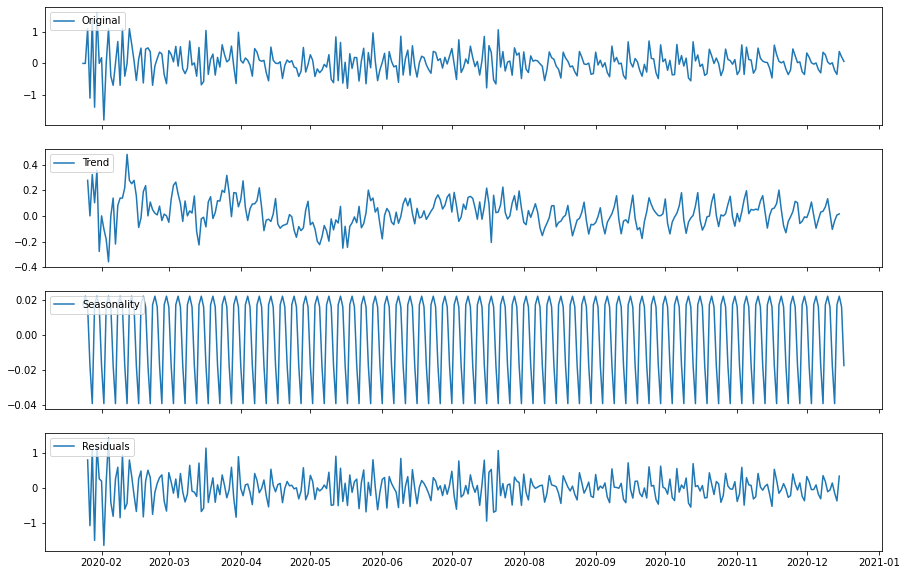

In [180]:
ss_decomposition = seasonal_decompose(x=stat_data , model='additive',period=5)
estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual = ss_decomposition.resid
# Pl o t s
fig, axes = plt.subplots(4, 1, sharex=True , sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)
axes[0].plot(stat_data , label='Original')
axes[0].legend(loc='upper left');
axes[1].plot(estimated_trend , label='Trend')
axes[1].legend(loc='upper left');
axes[2].plot(estimated_seasonal , label='Seasonality')
axes[2].legend(loc='upper left');
axes[3].plot(estimated_residual , label='Residuals')
axes[3].legend(loc='upper left');

## Training and Testing

In [153]:
train = stat_data[:-15]
test = stat_data[-15:]

In [215]:
print('Training size: ',train.shape)
print('Testing size: ',test.shape)

Training size:  (314,)
Testing size:  (15,)


In [154]:
time = train.index.append(test.index)

## MSE

In [131]:
def mse(observations , estimates):
    
    assert type(observations) == type(np.array([])), "'observations' must be a numpy array"
    assert type(estimates) == type(np.array([])), "'estimates' must be a numpy array"
    # check length of arrays equal
    assert len(observations) == len(estimates), "Arrays must be of equal length"
    # calculations
    difference = observations - estimates
    sq_diff = difference ** 2
    mse = sum(sq_diff)/ len(observations)
    return mse

## Models

### Triple Exponential Smoothing

In [263]:
triple = ExponentialSmoothing(train ,trend="additive", seasonal='additive', seasonal_periods =5).fit(optimized=True)
triple_preds = triple.forecast(len(test)).to_numpy()
triple_mse = mse(test.to_numpy() , triple_preds)
#print("Predictions: ", double_preds)
print("MSE: ", triple_mse)

C:\Users\EMILIO\anaconda3\envs\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\EMILIO\anaconda3\envs\tf\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


MSE:  0.04636625144113124


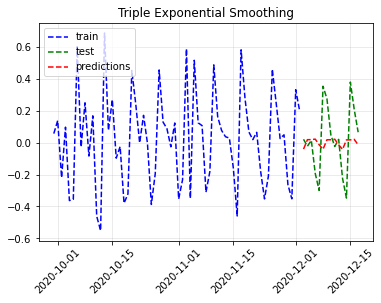

In [212]:
plt.plot(time[250:-15], train[250:] , 'b--', label="train")
plt.plot(time[-15:], test , color='g', linestyle="--",
label="test")
plt.plot(time[-15:], triple_preds , 'r--', label="predictions")
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.title("Triple Exponential Smoothing")
plt.grid(alpha=0.3);

### SARIMA

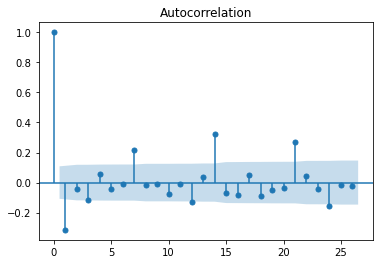

In [196]:
fig = sm.tsa.graphics.plot_acf(stat_data ,alpha=0.05,title = 'Autocorrelation')

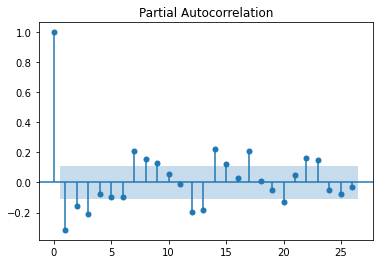

In [199]:
fig = sm.tsa.graphics.plot_pacf(stat_data,alpha=0.05, title = 'Partial Autocorrelation')

In [259]:
sar = sm.tsa.statespace.SARIMAX(train ,order=(2,0,4),seasonal_order=(1,1,1,6),trend='n').fit()
sar_pred = sar.forecast(len(test)).to_numpy()
sar_mse = mse(test.to_numpy() , sar_pred)
print("MSE: ", sar_mse)

C:\Users\EMILIO\anaconda3\envs\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\EMILIO\anaconda3\envs\tf\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


MSE:  0.042940401128189504


C:\Users\EMILIO\anaconda3\envs\tf\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


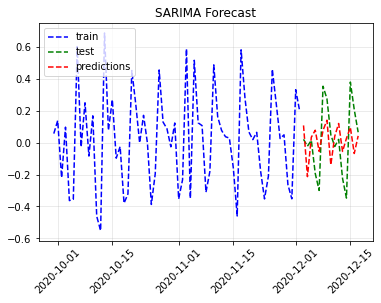

In [213]:
plt.plot(time[250:-15], train[250:] , 'b--', label="train")
plt.plot(time[-15:], test , color='g', linestyle="--",
label="test")
plt.plot(time[-15:], sar_pred , 'r--', label="predictions")
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.title("SARIMA Forecast")
plt.grid(alpha=0.3);

### RNN

In [214]:
def get_keras_format_series(series):
    """
    Convert a series to a numpy array of shape 
    [n_samples, time_steps, features]
    """
    
    series = np.array(series)
    return series.reshape(series.shape[0], series.shape[1], 1)

In [217]:
def get_train_test_data(forecast_series, input_days, 
                        test_days, sample_gap=3):
    """
    Utility processing function that splits an hourly time series into 
    train and test with keras-friendly format, according to user-specified
    choice of shape.    
    
    arguments
    ---------
    forecast_series: input series.
    input_hours (int): length of sequence input to network 
    test_days (int): length of held-out terminal sequence
    sample_gap (int): step size between start of train sequences; default 5
    
    returns
    ---------
    tuple: train_X, test_X_init, train_y, test_y     
    """

    train = forecast_series[:-test_days] # training data is remaining days until amount of test_hours
    test = forecast_series[-test_days:] # test data is the remaining test_hours

    train_X, train_y = [], []

    # range 0 through # of train samples - input_hours by sample_gap. 
    # This is to create many samples with corresponding
    for i in range(0, train.shape[0]-input_days, sample_gap): 
        train_X.append(train[i:i+input_days]) # each training sample is of length input hours
        train_y.append(train[i+input_days]) # each y is just the next step after training sample

    train_X = get_keras_format_series(train_X) # format our new training set to keras format
    train_y = np.array(train_y) # make sure y is an array to work properly with keras
    
    # The set that we had held out for testing (must be same length as original train input)
    test_X_init = test[:input_days] 
    test_y = test[input_days:] # test_y is remaining values from test set
    
    return train_X, test_X_init, train_y, test_y

In [219]:
input_days = 15
test_days = 30

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(stat_data, input_days, test_days))

In [220]:
print('Shapes: ')
print('\t train_X- ', train_X.shape)
print('\t train_y- ', train_y.shape)
print('\t test_X_init- ', test_X_init.shape)
print('\t test_y- ', test_y.shape)

Shapes: 
	 train_X-  (95, 15, 1)
	 train_y-  (95,)
	 test_X_init-  (15,)
	 test_y-  (15,)


In [222]:
def fit_SimpleRNN(train_X, train_y, cell_units, epochs):
    """
    Fit Simple RNN to data train_X, train_y 
    
    arguments
    ---------
    train_X (array): input sequence samples for training 
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for RNN cells  
    epochs (int): number of training epochs   
    """

    # initialize model
    model = Sequential() 
    
    # construct an RNN layer with specified number of hidden units
    # per cell and desired sequence input format 
    model.add(SimpleRNN(cell_units, input_shape=(train_X.shape[1],1)))
    
    # add an output layer to make final predictions 
    model.add(Dense(1))
    
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs) 
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=0)
    
    return model

In [223]:
model = fit_SimpleRNN(train_X, train_y, cell_units=10, epochs=10)

In [248]:
def predict(X_init, n_steps, model):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series      
    """
    
    X_init = np.array(X_init.copy()).reshape(1,-1,1)
    preds = []
    
    # iteratively take current input sequence, generate next step pred,
    # and shift input sequence forward by a step (to end with latest pred).
    # collect preds as we go.
    for _ in range(n_steps):
        pred = model.predict(X_init)
        preds.append(pred)
        X_init[:,:-1,:] = X_init[:,1:,:] # replace first 11 values with 2nd through 12th
        X_init[:,-1,:] = pred # replace 12th value with prediction
    
    preds = np.array(preds).reshape(-1,1)
    
    return preds

In [258]:
rnn_preds = predict(test_X_init, n_steps=len(test_y), model=model).reshape(-1,)
rnn_mse = mse(test_y.to_numpy() , rnn_preds)
print("MSE: ", rnn_mse)

MSE:  0.04892569303909718


In [256]:
rnn_preds.reshape(-1,).shape

(15,)

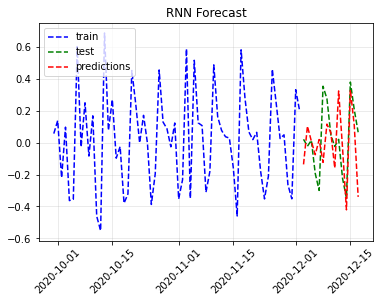

In [261]:
plt.plot(time[250:-15], train[250:] , 'b--', label="train")
plt.plot(time[-15:], test , color='g', linestyle="--",
label="test")
plt.plot(time[-15:], rnn_preds , 'r--', label="predictions")
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.title("RNN Forecast")
plt.grid(alpha=0.3);

## Errors

In [266]:
model_names = ['Triple Exp. Smoothing', 'SARIMA', 'RNN']
errors_df = pd.DataFrame([triple_mse, sar_mse, rnn_mse], index=model_names, columns=['MSE']).T
errors_df

,Triple Exp. Smoothing,SARIMA,RNN
MSE,0.046366,0.04294,0.048926


## Insights

In [269]:
preds_df = pd.DataFrame([triple_preds, sar_pred, rnn_preds], index=model_names, columns=time[-15:]).T
preds_df

,Triple Exp. Smoothing,SARIMA,RNN
Date,,,
2020-12-03,-0.041426,0.106989,-0.136704
2020-12-04,0.017982,-0.213256,0.102243
2020-12-05,0.018214,0.033370,0.009054
2020-12-06,0.021361,0.077011,-0.076181
2020-12-07,-0.013416,-0.054946,0.018594
2020-12-08,-0.042184,0.076035,-0.124181
2020-12-09,0.017224,0.139655,0.115231
2020-12-10,0.017456,-0.139374,0.062242
2020-12-11,0.020603,0.039569,-0.159330


In [290]:
def inv_transform(series):
    arr = []
    arr.append(data_jp.log_cases[-16]+series[0])
    for i in range(1,len(series)):
        dif = series[i]+arr[i-1]
        arr.append(dif)
    arr = np.expm1(arr)    
    return arr

In [292]:
preds_df['Triple_trans'] = inv_transform(preds_df['Triple Exp. Smoothing'])
preds_df['SARIMA_trans'] = inv_transform(preds_df['SARIMA'])
preds_df['RNN_trans'] = inv_transform(preds_df['RNN'])
preds_df

,Triple Exp. Smoothing,SARIMA,RNN,Triple_trans,SARIMA_trans,RNN_trans
Date,,,,,,
2020-12-03,-0.041426,0.106989,-0.136704,2356.296836,2733.448876,2142.064369
2020-12-04,0.017982,-0.213256,0.102243,2399.068515,2208.295145,2372.770514
2020-12-05,0.018214,0.033370,0.009054,2443.184867,2283.263601,2394.360921
2020-12-06,0.021361,0.077011,-0.076181,2495.957522,2466.128540,2218.658052
2020-12-07,-0.013416,-0.054946,0.018594,2462.681302,2334.227081,2260.316242
2020-12-08,-0.042184,0.076035,-0.124181,2360.915696,2518.710494,1996.239108
2020-12-09,0.017224,0.139655,0.115231,2401.948741,2896.357354,2240.168172
2020-12-10,0.017456,-0.139374,0.062242,2444.263504,2519.417680,2384.096025
2020-12-11,0.020603,0.039569,-0.159330,2495.166310,2621.147754,2032.807058


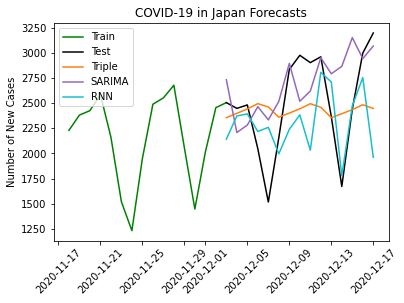

In [321]:
overall_time = data_jp.index
plt.plot(overall_time[300:-14], data_jp.New_Cases[300:-14], color='g',label='Train')
plt.plot(overall_time[-15:], data_jp.New_Cases[-15:], color='k', label='Test')
plt.plot(overall_time[-15:], preds_df['Triple_trans'] , 'tab:orange', label="Triple")
plt.plot(overall_time[-15:], preds_df['SARIMA_trans'] , 'tab:purple', label="SARIMA")
plt.plot(overall_time[-15:], preds_df['RNN_trans'] , 'tab:cyan', label="RNN")
plt.xticks(rotation=45)
plt.ylabel('Number of New Cases')
plt.legend()
plt.title('COVID-19 in Japan Forecasts')
plt.show()